In [2]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import diffusers
import torch
import torchvision
import os
import accelerate
#import pytorch_msssim
from fastai.vision.all import *
from fastai.vision.gan import *
from tqdm.auto import tqdm
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline, DDIMScheduler,StableDiffusionPipeline,DPMSolverMultistepScheduler
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
df=pd.read_csv('ArtEmisv1.csv')

In [4]:
def modo(x):
    if  x.value_counts()[0]>=sum(x.value_counts())*1.0 :
        return pd.Series.mode(x)
    else:
        return x.value_counts()[:3].index.tolist()

In [5]:
def emtype(x):
    if x.emotion=='sadness':
        return "negative"
    elif x.emotion=='fear':
        return "negative"
    elif x.emotion=='disgust':
        return "negative"
    elif x.emotion=='anger':
        return "negative"
    elif x.emotion=='contentment':
        return "positive"
    elif x.emotion=='awe':
        return "positive"
    elif x.emotion=='amusement':
        return "positive"
    elif x.emotion=='excitement':
        return "positive"
    else:
        return "something else"
    

In [6]:
dfemo=df
dfemo['emotype']= dfemo.apply(emtype,axis=1)


In [7]:
dfemo=dfemo.groupby(["art_style","painting"])["emotype"].agg(modo).reset_index()


In [8]:
t=type(dfemo.emotype[0])
dfemo=dfemo[dfemo["emotype"].apply(lambda x: type(x) !=t )].reset_index()
dfemo = dfemo.drop('index', axis=1)


In [9]:
dfemo=dfemo[dfemo.emotype!="something else"].reset_index()
dfemo = dfemo.drop('index', axis=1)


In [10]:
dfemo['path']= dfemo.apply(lambda x: 'dataset\\wikiart\\'+x['art_style']+"\\"+ x['painting']+".jpg", axis=1)


In [11]:
#frac=1-(dfemo.emotype.value_counts()[1]/dfemo.emotype.value_counts()[0])

#dfemo = dfemo.drop(dfemo[dfemo['emotype'] == "positive"].sample(frac=frac).index)


Text(0.5, 1.0, 'Histogram of Classes')

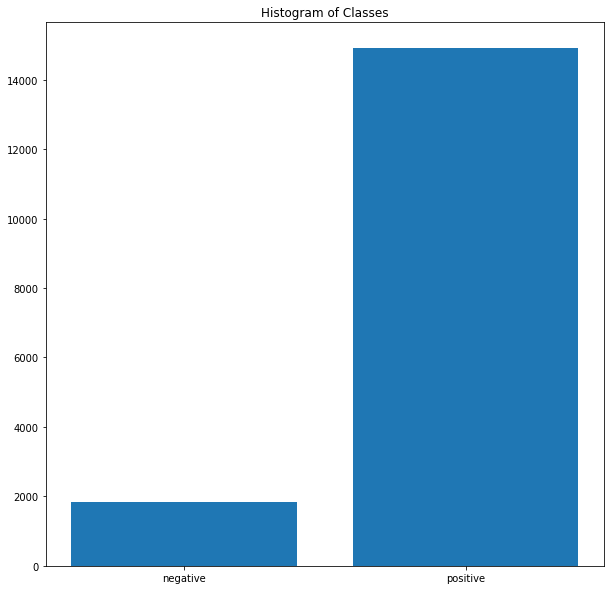

In [12]:
plt.figure(figsize=(10,10))
plt.hist(dfemo.emotype,bins=range(0,3), rwidth=0.8,align="left")
plt.title('Histogram of Classes')

In [18]:
dfemo[dfemo["emotype"]=="negative"]

,art_style,painting,emotype,path
0,Abstract_Expressionism,aaron-siskind_yuchitan-1-1955,negative,dataset\wikiart\Abstract_Expressionism\aaron-siskind_yuchitan-1-1955.jpg
1,Abstract_Expressionism,aki-kuroda_conti-nuit-1979,negative,dataset\wikiart\Abstract_Expressionism\aki-kuroda_conti-nuit-1979.jpg
11,Abstract_Expressionism,atsuko-tanaka_93e-1993,negative,dataset\wikiart\Abstract_Expressionism\atsuko-tanaka_93e-1993.jpg
22,Abstract_Expressionism,clyfford-still_1947-r-no-1-1947,negative,dataset\wikiart\Abstract_Expressionism\clyfford-still_1947-r-no-1-1947.jpg
23,Abstract_Expressionism,clyfford-still_ph-385-1949-no-1-1949,negative,dataset\wikiart\Abstract_Expressionism\clyfford-still_ph-385-1949-no-1-1949.jpg
...,...,...,...,...
16705,Ukiyo_e,utagawa-kuniyoshi_sotoku-invoking-a-thunder-storm,negative,dataset\wikiart\Ukiyo_e\utagawa-kuniyoshi_sotoku-invoking-a-thunder-storm.jpg
16707,Ukiyo_e,utagawa-kuniyoshi_tametomo-rescued-from-the-sea-monster-by-tengu,negative,dataset\wikiart\Ukiyo_e\utagawa-kuniyoshi_tametomo-rescued-from-the-sea-monster-by-tengu.jpg
16710,Ukiyo_e,utagawa-kuniyoshi_the-actor-15,negative,dataset\wikiart\Ukiyo_e\utagawa-kuniyoshi_the-actor-15.jpg
16713,Ukiyo_e,utagawa-kuniyoshi_the-ghost-in-the-lantern,negative,dataset\wikiart\Ukiyo_e\utagawa-kuniyoshi_the-ghost-in-the-lantern.jpg


In [ ]:
class SquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return torchvision.transforms.functional.pad(image, padding, 255, 'constant')

# now use it as the replacement of transforms.Pad class
transform=torchvision.transforms.Compose([
    SquarePad(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor()
])

In [ ]:
ds=torchvision.datasets.ImageFolder(root="diffset",transform=transform)


In [ ]:
# Feed it into a dataloader (batch size 8 here just for demo)
train_dataloader = DataLoader(ds, batch_size=16, shuffle=True)

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x).permute(1,2,0))


In [2]:
# modified from https://github.com/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb
class ClassConditionedUnet(nn.Module):
  def __init__(self, num_classes=2, class_emb_size=2):
    super().__init__()
    
    # The embedding layer will map the class label to a vector of size class_emb_size
    self.class_emb = nn.Embedding(num_classes, class_emb_size)

    # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
    self.model = UNet2DModel(
        sample_size=256,           # the target image resolution
        in_channels=3 + class_emb_size, # Additional input channels for class cond.
        out_channels=3,           # the number of output channels
        layers_per_block=4,       # how many ResNet layers to use per UNet block
        block_out_channels=(128, 128, 256,256,512,512), 
        down_block_types=( 
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "DownBlock2D",
            "AttnDownBlock2D",
            "DownBlock2D",
        ), 
        up_block_types=(
            "UpBlock2D", 
            "AttnUpBlock2D", 
            "UpBlock2D",      
            "UpBlock2D",
            "UpBlock2D", 
            "UpBlock2D",
          ),
    )

  # Our forward method now takes the class labels as an additional argument
  def forward(self, x, t, class_labels):
    # Shape of x:
    bs, ch, w, h = x.shape
    
    # class conditioning in right shape to add as additional input channels
    class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
    class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
    # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

    # Net input is now x and class cond concatenated together along dimension 1
    net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

    # Feed this to the unet alongside the timestep and return the prediction
    return self.model(net_input, t).sample # (bs, 1, 28, 28)

In [3]:

# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=500, beta_schedule='squaredcos_cap_v2')
     

In [ ]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(ds, batch_size=4, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our network 
net = ClassConditionedUnet().to("cuda")

# Our loss finction
loss_fn = pytorch_msssim.SSIM()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-5) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to("cuda")*2-1  # Data on the GPU (mapped to (-1, 1))
        y = y.to("cuda")
        noise = torch.randn_like(x)
        #timesteps = torch.randint(0, 999, (x.shape[0],)).long().to("cuda")
        timesteps=torch.randint(0, noise_scheduler.num_train_timesteps, (x.shape[0],)).long().to("cuda")
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
        
        # Get the model prediction
        
        pred = net(noisy_x, timesteps,y) # Note that we pass in the labels y
        
        # Calculate the loss
        loss = F.mse_loss(pred,noise)+(1-loss_fn(pred,noise)) # How close is the output to the noise
        #loss=F.mse_loss(pred,noise)
        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

In [ ]:
torch.save(net,r"D://EmotionalArtGeneration//epoch10ssim.pth")

In [4]:
netload=torch.load("D://EmotionalArtGeneration//epoch10.pth")

In [5]:
for j in range(20):
    # Prepare random x to start from, plus some desired labels y
    x = torch.randn(10, 3, 256, 256).to('cuda')
    y = torch.tensor([[i]*5 for i in range(2)]).flatten().to('cuda')
    # Sampling loop
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    
        # Get model pred
        with torch.no_grad():
            residual = netload(x, t,y)  # Again, note that we pass in our labels y
    
        # Update sample with step
        x = noise_scheduler.step(residual, t, x).prev_sample
    z=(x+1)/2
    p=z.detach().cpu()
    for k in range(p.shape[0]):
        #result=Image.fromarray(p[i].permute(1,2,0))
        if k<5:
            torchvision.utils.save_image(p[k],"results//negative//"+str(k+(j*10))+".png")
            #result.save("results//negative//"+str(i)+".png")
        else:
            torchvision.utils.save_image(p[k],"results//positive//"+str(k+j*10)+".png")
            #result.save("results//positive//"+str(i)+".png")
        
# Show the results
#fig, ax = plt.subplots(1, 1, figsize=(48, 48))
#ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(0, 255), nrow=8).permute(1,2,0))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]